<a href="https://colab.research.google.com/github/futartup/S11-assignment/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Add the current path to system path so that it can find the custom libraries

In [0]:
import os, sys
if '/content/drive/My Drive/Colab Notebooks/S11' not in sys.path:
  sys.path.append('/content/drive/My Drive/Colab Notebooks/S11')

# Import all the custom and inbuilt modules

In [0]:
!ls 
try:
  import ipynb
except:
  !pip install ipynb --upgrade
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import torch.optim as optim
import os, sys

from torchsummary import summary
import torch.optim as optim
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms.functional as F



# custom apis
from ipynb.fs.full.transform_train_test_loader import *
import ipynb.fs.full.conf as conf

from ipynb.fs.full.train import train_model
from ipynb.fs.full.copy_test import test_model
from ipynb.fs.full.utils import *
from ipynb.fs.full.lr_finder import *
# import gradcam 
from ipynb.fs.full.resnet_gradcam import *

data  drive  sample_data


  pip install torch-lr-finder -v --global-option="amp"


# The model related code. Load the model from the conf file. 

In [0]:

if conf.custom_model['use']:
  #use custom model
  pass
elif conf.inbuilt_model['use']:
  from ipynb.fs.full.model.pytorch_resnet import *
  from ipynb.fs.full.model.resnet import *
  from ipynb.fs.full.model.s11_resnet_dnn import NetS11
  model_type = conf.inbuilt_model['model']
  if model_type == 'DenseNet':
    net = globals()[model_type](growthRate=12, depth=50, reduction=0.5,
                            bottleneck=True, nClasses=10)
  else:
    net = globals()[model_type]()
  #net = torchvision.models.resnet18(pretrained=False)

# Model Summary

In [0]:
use_cuda = torch.cuda.is_available()
if use_cuda:
  torch.cuda.manual_seed(conf.seed)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = net.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1,

# Test and Train loader

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.031203836956604647, **conf.optimizer_parameters)

data_loader_obj = DataLoaderA(conf, './data')
train_loader = data_loader_obj.get_train_loader()
test_loader = data_loader_obj.get_test_loader()


Files already downloaded and verified


## Scheduler Call and LR Range finder

In [0]:
#lr_range_obj = LRRangeFinder(model=model, epochs=10, start_lr=1e-7, end_lr=1.0, dataloader=train_loader, trainlen=len(train_loader), batch_size=conf.batch_size, device=device)
#max_lr = lr_range_obj.findLR()
#print(max_lr)


# Visualize the transformed images

In [0]:
classes = {
    0 : "airplane",
    1 : "automobile",
    2 : "bird",
    3 : "cat",
    4 : "deer",
    5 : "dog",
    6 : "frog",
    7 : "horse",
    8 : "ship",
    9 : "truck",
}

# images, labels = next(iter(train_loader))
# images = images.numpy()  # convert images to numpy for display

# # plot the images in the batch, along with the corresponding labels
# fig = plt.figure(figsize=(32, 32))
# # display 20 images
# for idx in np.arange(20):
#     ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
#     ax.imshow(images[idx].transpose((1, 2, 0)))
#     ax.set_title(classes[labels[idx].item()])

# Find the best LR

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


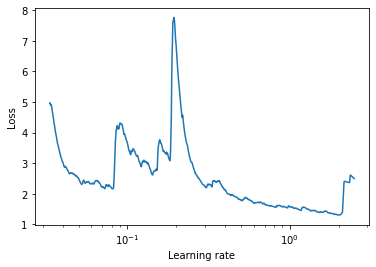

0.03152880527576345
1.9884433935301773
1.9884433935301773


In [0]:
if conf.use_lr_finder_train:
  lr_finder = LRFinder(model, optimizer, criterion, device) #implemented LRFinder for SGD
  lr_finder.range_test(train_loader, end_lr=5, num_iter=len(train_loader)*10, step_mode="exp")
  lr_finder.plot() # to inspect the loss-learning rate graph
  #print(lr_finder.history) # see the history
  best_loss = lr_finder.best_loss
  print(min(lr_finder.history['lr']))
  print(lr_finder.history['lr'][lr_finder.history['loss'].index(best_loss)])
  optimizer.lr = lr_finder.history['lr'][lr_finder.history['loss'].index(best_loss)]
  lr_finder.reset()
  loss = lr_finder.history['loss']
  lr = lr_finder.history['lr']
  print(lr[loss.index(min(loss))])

  #max_lr = min(lr_finder.history['lr'])
scheduler = conf.scheduler(optimizer, steps_per_epoch=int(len(train_loader))+ 1, **conf.scheduler_parameters )

# Test and Train

In [0]:
# Containers to plot the graph for test and train
test_losses = []
test_acc = []
train_losses = []
train_acc = []

lr_array = []

# Containers for correctly and falsely predicted images
correct_predicted = []
false_predicted = []

# Number of images to display which are correct and false predicted
sample_count = 25

# TODO: Take the end epoch value from conf file 
for e in range(1, conf.epochs):
    print("epoch no: {}\n".format(e))
    print("Learning rate : {}\n".format(scheduler.get_lr()))
    train_model(model, device, 
                train_loader, optimizer, 
                criterion, e,
                train_losses, train_acc, lr_array, scheduler)
    #scheduler.step()
    test_loss = test_model(model, device, 
                           test_loader, criterion, 
                           2, sample_count,
                           correct_predicted, false_predicted, 
                           test_losses, test_acc, e)
    
    print("===========================================================\n")



  0%|          | 0/98 [00:00<?, ?it/s]

epoch no: 1

Learning rate : [0.0004]



/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=30.026836395263672 Batch_id=97 Accuracy=32.94: 100%|██████████| 98/98 [00:17<00:00,  5.50it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.4626, Accuracy: 4668/10000 (46.68%)


epoch no: 2

Learning rate : [0.0023839730071699705]



Loss=26.734161376953125 Batch_id=97 Accuracy=52.49: 100%|██████████| 98/98 [00:17<00:00,  5.49it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.1681, Accuracy: 5876/10000 (58.76%)


epoch no: 3

Learning rate : [0.004367946014339941]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9201, Accuracy: 6805/10000 (68.05%)


epoch no: 4

Learning rate : [0.006351919021509911]



Loss=17.564434051513672 Batch_id=97 Accuracy=68.54: 100%|██████████| 98/98 [00:18<00:00,  5.39it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8463, Accuracy: 7001/10000 (70.01%)


epoch no: 5

Learning rate : [0.00833589202867988]



Loss=12.678557395935059 Batch_id=97 Accuracy=71.68: 100%|██████████| 98/98 [00:18<00:00,  5.44it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9521, Accuracy: 6909/10000 (69.09%)


epoch no: 6

Learning rate : [0.009916877436868688]



  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8979, Accuracy: 6946/10000 (69.46%)


epoch no: 7

Learning rate : [0.009401307108585858]



Loss=6.562751770019531 Batch_id=97 Accuracy=77.32: 100%|██████████| 98/98 [00:18<00:00,  5.42it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6643, Accuracy: 7773/10000 (77.73%)


epoch no: 8

Learning rate : [0.00888573678030303]



Loss=5.0969038009643555 Batch_id=97 Accuracy=78.36: 100%|██████████| 98/98 [00:17<00:00,  5.45it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6737, Accuracy: 7693/10000 (76.93%)


epoch no: 9

Learning rate : [0.008370166452020203]



Loss=4.393881320953369 Batch_id=97 Accuracy=79.03: 100%|██████████| 98/98 [00:18<00:00,  5.44it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8571, Accuracy: 7407/10000 (74.07%)


epoch no: 10

Learning rate : [0.007854596123737373]



Loss=4.024288654327393 Batch_id=97 Accuracy=79.68: 100%|██████████| 98/98 [00:17<00:00,  5.52it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8707, Accuracy: 7191/10000 (71.91%)


epoch no: 11

Learning rate : [0.007339025795454546]



Loss=3.589423656463623 Batch_id=97 Accuracy=80.75: 100%|██████████| 98/98 [00:18<00:00,  5.44it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.2543, Accuracy: 6142/10000 (61.42%)


epoch no: 12

Learning rate : [0.006823455467171717]



Loss=3.3054826259613037 Batch_id=97 Accuracy=81.45: 100%|██████████| 98/98 [00:17<00:00,  5.49it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6604, Accuracy: 7876/10000 (78.76%)


epoch no: 13

Learning rate : [0.006307885138888889]



Loss=3.043071746826172 Batch_id=97 Accuracy=82.01: 100%|██████████| 98/98 [00:17<00:00,  5.46it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5748, Accuracy: 8049/10000 (80.49%)


epoch no: 14

Learning rate : [0.005792314810606061]



Loss=2.9796574115753174 Batch_id=97 Accuracy=82.58: 100%|██████████| 98/98 [00:18<00:00,  5.42it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6315, Accuracy: 7900/10000 (79.00%)


epoch no: 15

Learning rate : [0.0052767444823232324]



Loss=2.855430841445923 Batch_id=97 Accuracy=83.32: 100%|██████████| 98/98 [00:18<00:00,  5.42it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5576, Accuracy: 8166/10000 (81.66%)


epoch no: 16

Learning rate : [0.004761174154040404]



Loss=2.8569164276123047 Batch_id=97 Accuracy=84.20: 100%|██████████| 98/98 [00:18<00:00,  5.43it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5560, Accuracy: 8149/10000 (81.49%)


epoch no: 17

Learning rate : [0.004245603825757576]



Loss=2.7171878814697266 Batch_id=97 Accuracy=84.96: 100%|██████████| 98/98 [00:17<00:00,  5.45it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5860, Accuracy: 8052/10000 (80.52%)


epoch no: 18

Learning rate : [0.003730033497474748]



Loss=2.7004776000976562 Batch_id=97 Accuracy=85.89: 100%|██████████| 98/98 [00:17<00:00,  5.49it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5961, Accuracy: 8109/10000 (81.09%)


epoch no: 19

Learning rate : [0.003214463169191919]



Loss=2.5906126499176025 Batch_id=97 Accuracy=86.80: 100%|██████████| 98/98 [00:18<00:00,  5.44it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5529, Accuracy: 8189/10000 (81.89%)


epoch no: 20

Learning rate : [0.002698892840909091]



Loss=2.4506447315216064 Batch_id=97 Accuracy=87.72: 100%|██████████| 98/98 [00:18<00:00,  5.40it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6061, Accuracy: 8045/10000 (80.45%)


epoch no: 21

Learning rate : [0.0021833225126262623]



Loss=2.405841112136841 Batch_id=97 Accuracy=88.60: 100%|██████████| 98/98 [00:17<00:00,  5.46it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4174, Accuracy: 8611/10000 (86.11%)


epoch no: 22

Learning rate : [0.0016677521843434344]



Loss=2.2919559478759766 Batch_id=97 Accuracy=90.14: 100%|██████████| 98/98 [00:18<00:00,  5.43it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4156, Accuracy: 8627/10000 (86.27%)


epoch no: 23

Learning rate : [0.0011521818560606065]



Loss=2.1572883129119873 Batch_id=97 Accuracy=92.00: 100%|██████████| 98/98 [00:18<00:00,  5.42it/s]



Test set: Average loss: 0.3352, Accuracy: 8884/10000 (91.73%)




# *GradCam* for Resnet for falsely predicted images


In [0]:
# images = [x['image'].unsqueeze(0) for x in false_predicted]
# inputs = [i.to(device) for i in images]
# gradcamof(model, inputs, classes)

# Correctly predicted images

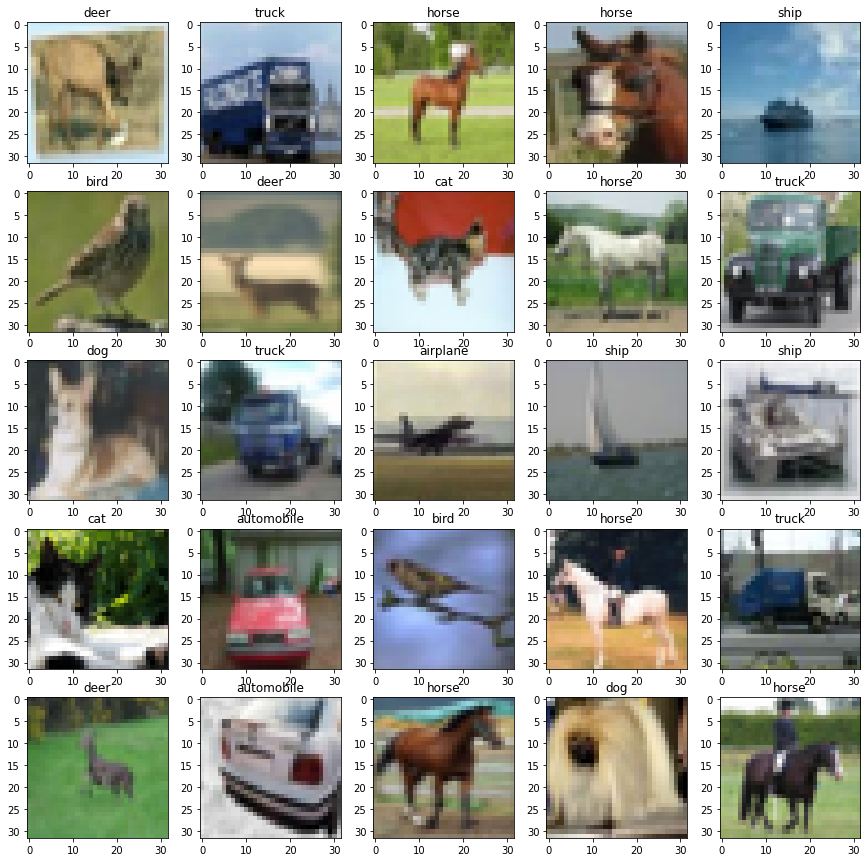

In [0]:
matplotlib_imshow(classes, correct_predicted, plt, False)

# Falsely predicted images

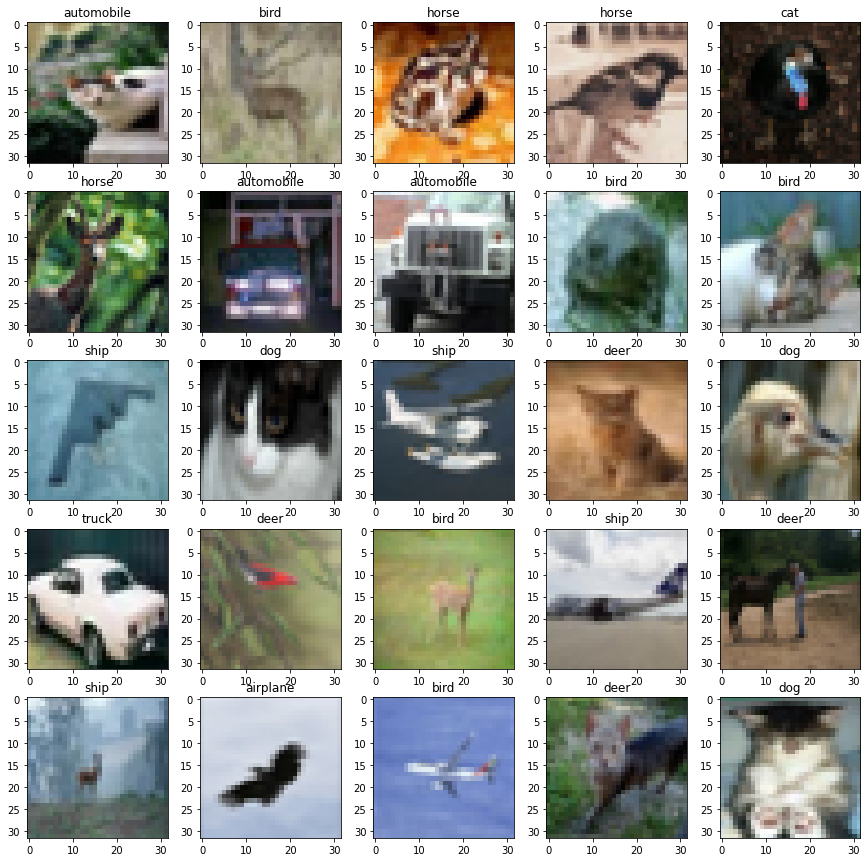

In [0]:
matplotlib_imshow(classes, false_predicted, plt, False)

# Plot The Graph for train and test 

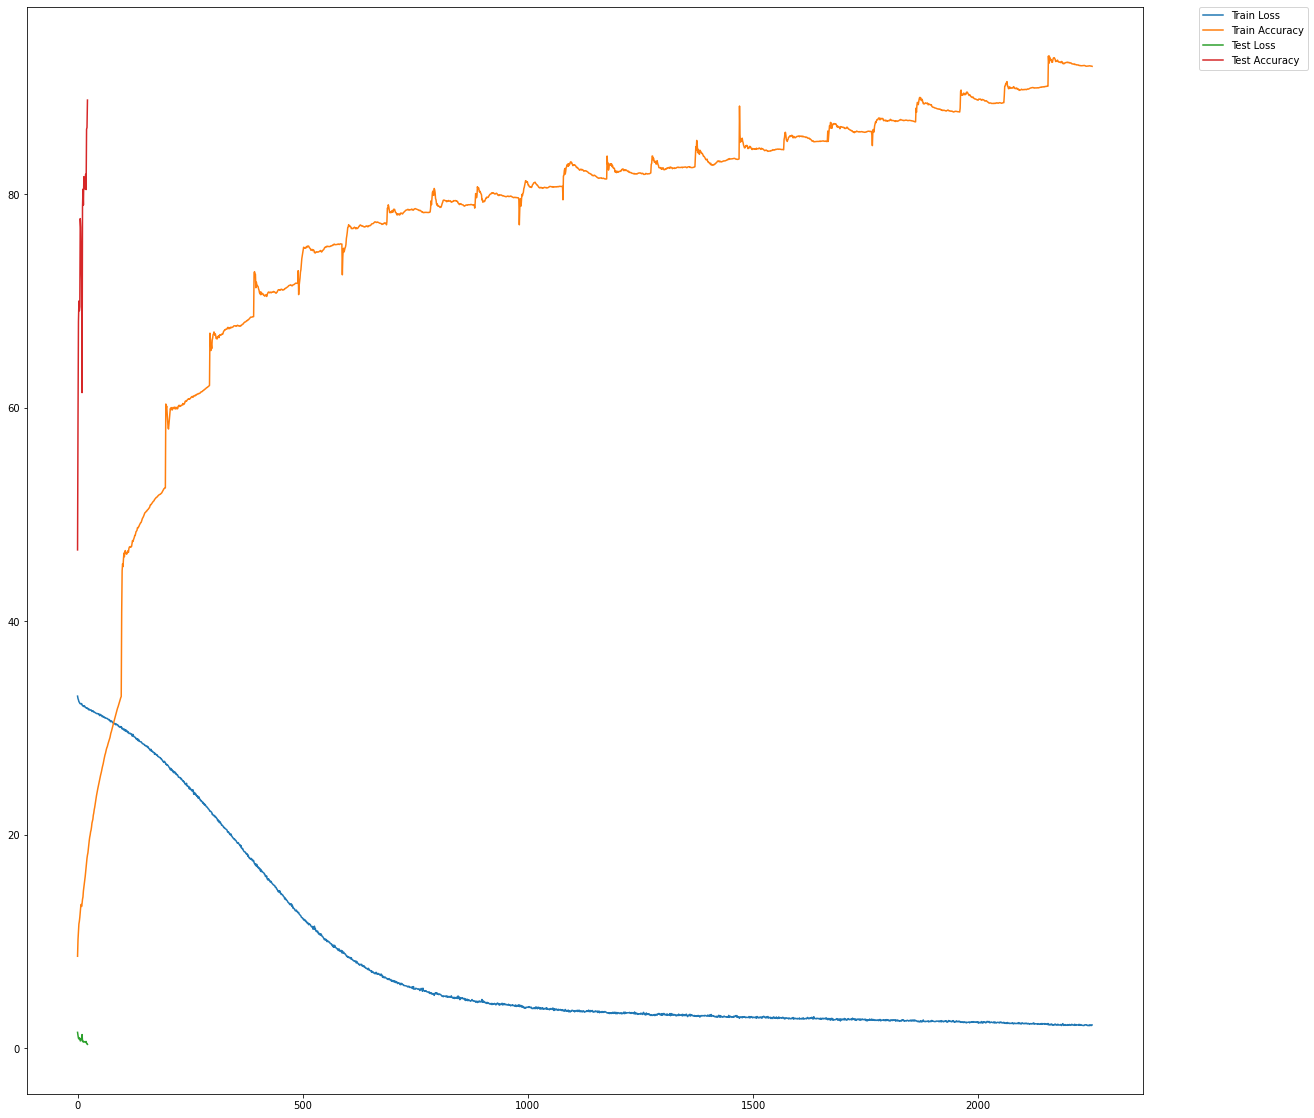

In [0]:
plottesttraingraph([x.item() for x in train_losses], train_acc, test_losses, test_acc, plt, True)